In [409]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris


# Import PySwarms
import pyswarms as ps

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [410]:
n_inputs = 4
n_hidden = 20
n_classes = 3

num_samples = 112

index = 0
fitness = []
indexes = []

In [411]:
def logits_function(p, X, y):
    # Roll-back the weights and biases
    W1 = p[0:80].reshape((n_inputs,n_hidden))
    b1 = p[80:100].reshape((n_hidden,))
    W2 = p[100:160].reshape((n_hidden,n_classes))
    b2 = p[160:163].reshape((n_classes,))

    # Perform forward propagation
    z1 = X.dot(W1) + b1  # Pre-activation in Layer 1
    a1 = np.tanh(z1)     # Activation in Layer 1
    logits = a1.dot(W2) + b2 # Pre-activation in Layer 2

    if y is not None and (len(indexes) == 0 or index != indexes[len(fitness)-1]):
        y_pred = np.argmax(logits, axis=1)
        score = (y_pred == y).sum() / y.shape[0]

        if  len(fitness) == 0 or score > fitness[len(fitness)-1] :
            fitness.append(score)
            indexes.append(index)

    return logits          # Logits for Layer 2

In [412]:
# Forward propagation
def forward_prop(params, X,y):
    logits = logits_function(params, X, y)

    # Compute for the softmax of the logits
    exp_scores = np.exp(logits)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    # Compute for the negative log likelihood

    corect_logprobs = -np.log(probs[range(num_samples), y])
    loss = np.sum(corect_logprobs) / num_samples

    return loss

In [413]:
def Get_PSO(f):
    # Initialize swarm
    options = {'c1': 2.05, 'c2': 2.05, 'w': 0.729}

    # Call instance of PSO
    dimensions = (n_inputs * n_hidden) + (n_hidden * n_classes) + n_hidden + n_classes
    optimizer = ps.single.GlobalBestPSO(n_particles=50, dimensions=dimensions, options=options)

    # Perform optimization
    cost, pos = optimizer.optimize(f, iters=1000)
    return pos

In [414]:
def predict(pos, X):
    logits = logits_function(pos, X, None)
    y_pred = np.argmax(logits, axis=1)
    return y_pred

In [415]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")


labelencoder = LabelEncoder()

def Start_Iris():
    data = pd.read_csv('databases/iris.data', names = ['sepal length', 'sepal width', 'petal length', 'petal width', 'class'])
    target = labelencoder.fit_transform(data['class'].values)
    data = data.drop('class', axis = 1).values

    sc = StandardScaler()
    data = sc.fit_transform(data)

    x_train, x_test, y_train, y_test = train_test_split(data, target)

    def f(x):
        global index
        n_particles = x.shape[0]
        j = [forward_prop(x[i], x_train, y_train) for i in range(n_particles)]
        index += 1
        return np.array(j)

    pos = Get_PSO(f)
    scores = (predict(pos, x_test) == y_test)

    print("\n Iris \n")
    print("Accuracy: %.2f%%" % (100 * np.mean(scores)))

In [416]:
Start_Iris()

print(indexes)
print(fitness)

2022-03-27 02:29:04,621 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.3}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.00662
2022-03-27 02:29:10,053 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.006622107569159532, best pos: [ 7.18826519e-01  4.00505304e-01  2.95385806e+00  9.68607858e-01
 -1.49694958e-01  9.19510521e-02  6.29418443e-01 -3.54822264e-01
 -1.79457675e+02  1.91629227e-01  4.37303917e-01  1.06963554e+00
 -8.64849096e+00 -3.82161305e-01  9.96531130e-02  2.82198272e+01
  5.22589014e-01  1.04674147e+00  2.08821955e+00 -3.13392080e+00
  3.56968047e+01  2.39747511e-01  2.75525192e+00  1.66253693e+00
  3.55284245e-01  7.36837985e-02  2.56019047e+01  2.03436383e+00
  3.25306924e-01  4.43162036e-01  1.85113278e+02 -4.78120462e-01
  4.57604531e+00  4.69388364e-01  6.68383886e-01  3.13832970e-01
  1.28470047e+00 -6.66436173e-01  1.33870072e+00 -3.68634244e+00
  3.36099274e+00 -1


 Iris 

Accuracy: 97.37%
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 48, 308]
[0.26785714285714285, 0.44642857142857145, 0.6696428571428571, 0.7678571428571429, 0.7946428571428571, 0.8303571428571429, 0.8839285714285714, 0.8928571428571429, 0.9196428571428571, 0.9464285714285714, 0.9553571428571429, 0.9821428571428571, 0.9910714285714286, 1.0]


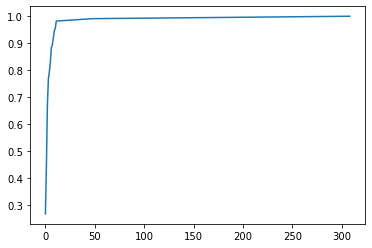

In [417]:
#plot indexes and fitness
plt.plot(indexes, fitness)